*Lab 1: Simple Example*
- Let's look at the ODE:
$$\frac{du}{dt}=\cos{2\pi t} $$
- Initial condition:
$$u(0)=1$$
- The exact solution:
$$u(t)=\frac{1}{2\pi}\sin{2\pi}t+1$$
- Make a neural network and loss functions like below:
<center><img src="images/pinn.png" width=800></center>

- Install and Setup
    - Tensorflow <= 2.2.0, Tensorfow robability >= 0.10.0

In [4]:
!pip install tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 11.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.3 MB/s eta 0:00:00
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)


In [5]:
# Import Library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2023-06-16 21:39:03.104187: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Define Network and Hyper-parameters
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Set Optimizer
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

# Define ODE System
- ODE loss:
$$L_{ODE}=\frac{1}{n}\sum_{i=1}^{n}(\frac{dNN(t_i)}{dt}-\cos2 \pi t_i)^2$$

- Initial condition loss:
$$L_{IC}=\frac{1}{n}\sum_{i=1}^{n}(NN(0)-1)^2$$

- Total loss:

$$L_{Total}=L_{ODE}+L_{IC}$$

In [8]:
def ode_system(t, net):
    t = t.reshape(-1,1)
    t = tf.constant(t, dtype = tf.float32)
    t_0 = tf.zeros((1,1))
    one = tf.ones((1,1))

    with tf.GradientTape() as tape:
        tape.watch(t)

        u = net(t)
        u_t = tape.gradient(u, t)

    ode_loss = u_t - tf.math.cos(2*np.pi*t)
    IC_loss = net(t_0) - one

    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

1.5500488
0.4173257
0.18641283
0.049591646
0.0070791016
0.002529311


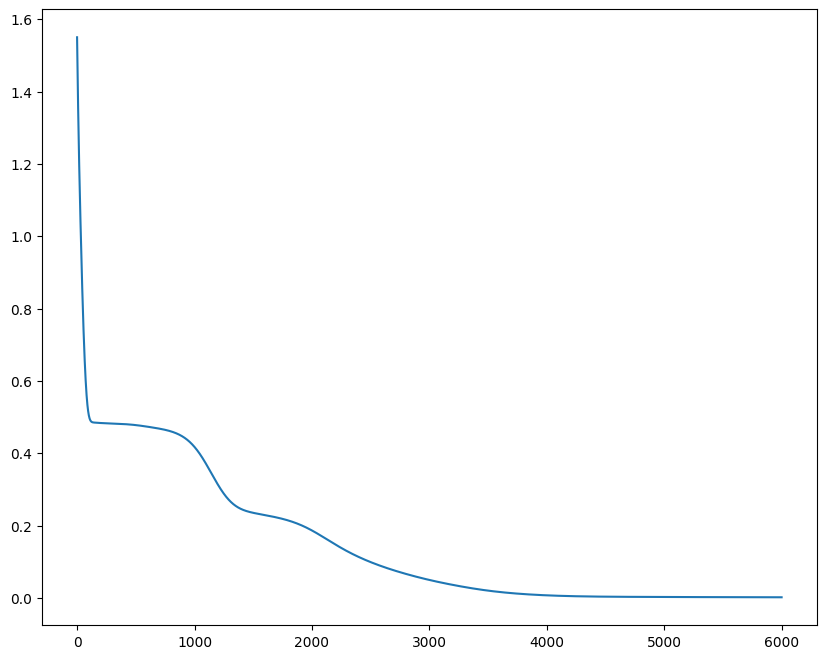

In [9]:
# Train
train_t = (np.random.rand(30)*2).reshape(-1, 1)
train_loss_record = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())

plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()

4/4 [==============================] - 0s 1ms/step


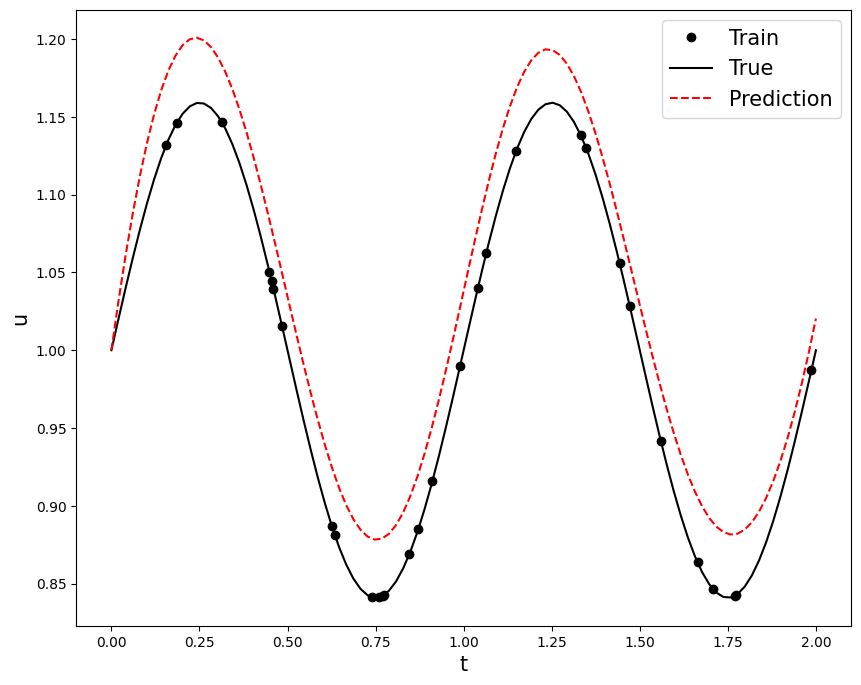

In [10]:
# Prediction
test_t = np.linspace(0, 2, 100)

train_u = np.sin(2*np.pi*train_t)/(2*np.pi) + 1
true_u = np.sin(2*np.pi*test_t)/(2*np.pi) + 1
pred_u = NN.predict(test_t).ravel()

plt.figure(figsize = (10,8))
plt.plot(train_t, train_u, 'ok', label = 'Train')
plt.plot(test_t, true_u, '-k',label = 'True')
plt.plot(test_t, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()

Lab 2: Solve Lab 1 Again using DeepXDE

- DeepXDE
Using DeepXDE libray
DeepXDE is a useful library for solving forward and inverse partial differential equations (PDEs) via physics-informed neural network (PINN)

In [11]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 1.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 15.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 10.6 MB/s eta 0:00:00


# Problem Setup Again
- ODE loss:
$$\frac{du}{dt}=\cos 2 \pi t$$

- Initial condition loss:
$$u(0) = 1$$

- Total loss:

$$u(t) = \frac{1}{2\pi} \sin 2\pi t + 1$$

In [12]:
# import library
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import math as m

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



In [13]:
# Define ODE System
pi = tf.constant(m.pi)

def ode_system(t, u):
    du_t = dde.grad.jacobian(u, t)
    return du_t - tf.math.cos(2*pi*t)

In [14]:
# Define Initial condition
def boundary(t, on_initial):
    return on_initial and np.isclose(t[0], 0)

In [15]:
# Define Geometry & Implement Initial Condition
geom = dde.geometry.TimeDomain(0, 2)

ic = dde.IC(geom, lambda t: 1, boundary)

# Reference solution to compute the error
def true_solution(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

data = dde.data.PDE(geom,
                    ode_system,
                    ic,
                    num_domain = 30,
                    num_boundary = 2,
                    solution = true_solution,
                    num_test = 100)

In [16]:
# Define Network and Hyper-parameters
layer_size = [1] + [32] + [1]
activation = "tanh"
initializer = "Glorot uniform"

NN = dde.maps.FNN(layer_size, activation, initializer)

In [17]:
model = dde.Model(data, NN)
model.compile("adam", lr = 0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.031681 s

'compile' took 0.186207 s



/Users/wonderit/anaconda3/envs/DAIC/lib/python3.8/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Training model...

Step      Train loss              Test loss               Test metric
0         [6.83e-01, 1.00e+00]    [6.85e-01, 1.00e+00]    []  
1000      [4.97e-01, 1.17e-05]    [4.91e-01, 1.17e-05]    []  
2000      [2.73e-01, 3.28e-05]    [2.82e-01, 3.28e-05]    []  
3000      [2.05e-01, 2.07e-06]    [2.17e-01, 2.07e-06]    []  
4000      [4.98e-02, 8.78e-08]    [5.49e-02, 8.78e-08]    []  
5000      [5.00e-03, 2.45e-09]    [4.03e-03, 2.45e-09]    []  
6000      [1.48e-03, 9.50e-10]    [1.14e-03, 9.50e-10]    []  

Best model at step 6000:
  train loss: 1.48e-03
  test loss: 1.14e-03
  test metric: []

'train' took 2.476677 s



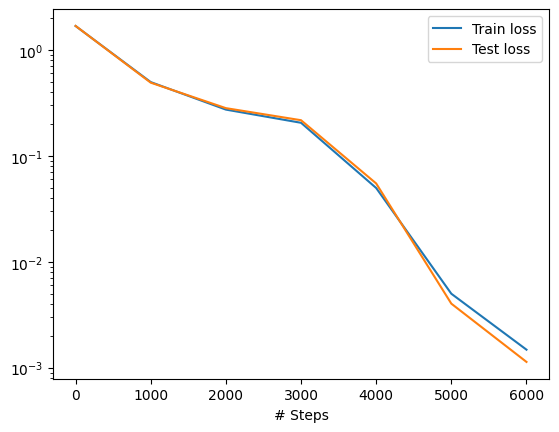

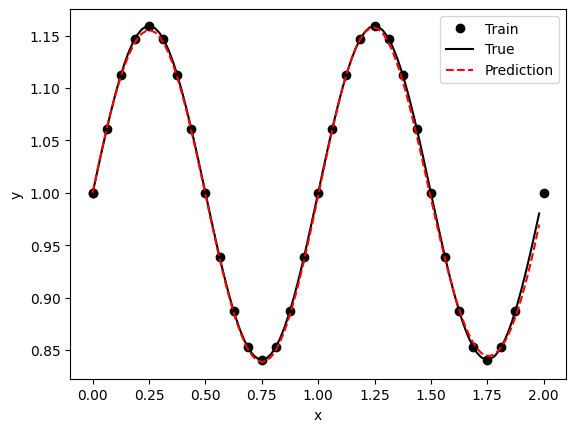

In [18]:
# Train & Prediction
losshistory, train_state = model.train(epochs = 6000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)